# Per-qubit Noise Quickstart Test

We fabricate a synthetic set of $T_1/T_2$ values, map them onto Stim's rotated
surface-code memory circuits, and benchmark logical performance under two noise
models:

- **i.i.d. model**: every qubit experiences the same physical error probability.
- **i.n.i.d. model**: per-qubit Pauli channels derived from the heterogeneous
  $T_1/T_2$ data.

For each code distance we estimate a *probability pseudo-threshold*: the physical
error probability where the logical error rate matches the physical one
($P_L(p) = p$).

In [1]:
# BPOSD
# collected_surface_code_stats = sinter.collect(
#     num_workers=144,
#     tasks=surface_code_tasks,
#     decoders=['bposd'],
#     max_shots=10_000_000,
#     max_errors=500_000,
#     print_progress=True,
#     custom_decoders=sinter_decoders(),
#     # save_resume_filepath="iid.checkpoint"
# )

In [2]:
import os
import sys
from collections import defaultdict
from typing import Dict, Iterable, List, Mapping, MutableMapping, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import stim
import sinter
from stimbposd import SinterDecoder_BPOSD, sinter_decoders

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.append(root)

from scripts.circuit_pauli_override import *

# from prod.per_qubit_noise import (
#     unrotated_data_qubits,
#     maps_from_t1_t2,
#     build_unrotated_memory_circuit_with_per_qubit_noise,
#     mean_total_pauli_probability,
#     constant_maps_from_uniform,
#  )

print('stim', stim.__version__)
print('sinter', getattr(sinter, '__version__', ''))



stim 1.15.0
sinter 1.15.0


In [3]:
def unrotated_memory_qubits(
    distance: int,
    rounds: int,
    *,
    task: str = "surface_code:unrotated_memory_z",
) -> List[int]:
    """Return sorted qubit indices used by the generated surface-code circuit."""

    marker = stim.Circuit.generated(
        task,
        rounds=rounds,
        distance=distance,
        after_clifford_depolarization=0.0,
        after_reset_flip_probability=0.0,
        before_measure_flip_probability=0.0,
        before_round_data_depolarization=0.0,
    )
    qubits = set()
    for op in marker:
        if op.name == "QUBIT_COORDS":
            for target in op.targets_copy():
                qubits.add(int(target.value))
    return sorted(qubits)

## Generate synthetic $T_1/T_2$ data

In [4]:
distance_3_t12 = [
    (0, 43.6, 12.2),
    (1, 100.7, 159.0),
    (2, 103.3, 182.8),
    (3, 110.9, 228.6),
    (4, 123.1, 114.0),
    (5, 111.0, 215.8),
    (6, 107.6, 133.7),
    (7, 101.8, 158.8),
    (8, 16.5, 100.0),
    (9, 77.6, 11.6),
    (10, 61.1, 8.6),
    (11, 71.1, 11.2),
    (12, 66.9, 11.9),
]

distance_5_t12 = [
    (0, 65.5, 33.0),
    (1, 34.7, 69.4),
    (2, 89.8, 111.6),
    (3, 96.7, 90.7),
    (4, 91.1, 130.0),
    (5, 94.9, 91.7),
    (6, 92.0, 187.7),
    (7, 95.3, 155.8),
    (8, 98.3, 110.1),
    (9, 100.7, 159.0),
    (10, 103.3, 182.8),
    (11, 110.9, 228.6),
    (12, 123.1, 114.0),
    (13, 111.0, 215.8),
    (14, 107.6, 133.7),
    (15, 101.8, 158.8),
    (16, 98.4, 161.7),
    (17, 97.2, 151.2),
    (18, 93.0, 116.5),
    (19, 91.7, 131.4),
    (20, 91.6, 179.1),
    (21, 90.7, 151.2),
    (22, 90.5, 122.4),
    (23, 89.7, 37.2),
    (24, 33.6, 101.9),
    (25, 72.3, 25.6),
    (26, 52.7, 21.6),
    (27, 86.9, 20.2),
    (28, 83.5, 17.9),
    (29, 68.9, 17.0),
    (30, 43.6, 12.2),
    (31, 77.6, 11.6),
    (32, 61.1, 8.6),
    (33, 71.1, 11.2),
    (34, 66.9, 11.9),
    (35, 16.5, 100.0),
    (36, 72.8, 17.6),
    (37, 83.5, 19.2),
    (38, 78.0, 21.0),
    (39, 57.8, 25.1),
    (40, 29.9, 47.0),
]

distance_7_t12 = [
    (0, 50.8, 86.1),
    (1, 53.3, 64.1),
    (2, 54.4, 117.4),
    (3, 78.5, 159.1),
    (4, 79.0, 80.8),
    (5, 81.3, 140.5),
    (6, 82.6, 117.8),
    (7, 83.1, 98.4),
    (8, 83.8, 199.4),
    (9, 84.4, 161.0),
    (10, 84.8, 84.5),
    (11, 86.8, 120.0),
    (12, 88.5, 144.8),
    (13, 89.3, 147.7),
    (14, 89.8, 111.6),
    (15, 96.7, 90.7),
    (16, 91.1, 130.0),
    (17, 94.9, 91.7),
    (18, 92.0, 187.7),
    (19, 95.3, 155.8),
    (20, 98.3, 110.1),
    (21, 100.7, 159.0),
    (22, 103.3, 182.8),
    (23, 110.9, 228.6),
    (24, 123.1, 114.0),
    (25, 111.0, 215.8),
    (26, 107.6, 133.7),
    (27, 101.8, 158.8),
    (28, 98.4, 161.7),
    (29, 97.2, 151.2),
    (30, 93.0, 116.5),
    (31, 91.7, 131.4),
    (32, 91.6, 179.1),
    (33, 90.7, 151.2),
    (34, 90.5, 122.4),
    (35, 89.6, 154.0),
    (36, 88.7, 155.3),
    (37, 88.4, 131.1),
    (38, 85.8, 140.0),
    (39, 84.4, 115.5),
    (40, 84.1, 168.6),
    (41, 118.4, 83.2),
    (42, 82.9, 172.6),
    (43, 82.0, 140.0),
    (44, 81.3, 104.0),
    (45, 78.9, 95.2),
    (46, 55.6, 119.9),
    (47, 53.7, 113.4),
    (48, 52.9, 127.3),
    (49, 71.7, 48.4),
    (50, 54.5, 46.1),
    (51, 70.4, 44.7),
    (52, 74.4, 44.5),
    (53, 54.1, 42.0),
    (54, 41.1, 150.5),
    (55, 71.8, 38.8),
    (56, 38.1, 95.0),
    (57, 34.7, 39.4),
    (58, 65.5, 33.0),
    (59, 72.3, 25.6),
    (60, 52.7, 21.6),
    (61, 86.9, 20.2),
    (62, 83.5, 17.9),
    (63, 68.9, 17.0),
    (64, 43.6, 12.2),
    (65, 77.6, 11.6),
    (66, 61.1, 8.6),
    (67, 71.1, 11.2),
    (68, 66.9, 11.9),
    (69, 16.5, 100.0),
    (70, 72.8, 17.6),
    (71, 83.5, 19.2),
    (72, 78.0, 21.0),
    (73, 57.8, 25.1),
    (74, 29.9, 47.0),
    (75, 33.6, 101.9),
    (76, 89.7, 37.2),
    (77, 38.1, 53.0),
    (78, 39.6, 80.0),
    (79, 73.3, 41.9),
    (80, 44.3, 80.4),
    (81, 44.7, 81.7),
    (82, 111.7, 44.8),
    (83, 74.0, 47.4),
    (84, 70.1, 50.7),
]


distance_3_t12 = fix_physical_t1_t1(distance_3_t12)
distance_5_t12 = fix_physical_t1_t1(distance_5_t12)
distance_7_t12 = fix_physical_t1_t1(distance_7_t12)

## Map device data to Stim qubits

In [5]:
rng = np.random.default_rng(seed=23)

distances = [3, 5, 7]
rounds_per_distance = {d: d * 3 for d in distances}

qubits_by_distance = {
    d: unrotated_memory_qubits(distance=d, rounds=rounds_per_distance[d])
    for d in distances
}

base_tables = {
    3: np.array(distance_3_t12, dtype=object),
    5: np.array(distance_5_t12, dtype=object),
    7: np.array(distance_7_t12, dtype=object),
}

def sample_qubit_layout(distance: int, rng) -> dict[int, tuple[float, float]]:
    qubits = qubits_by_distance[distance]
    table = base_tables[distance]
    repeats = (len(qubits) + len(table) - 1) // len(table)
    expanded = np.tile(table, (repeats, 1))[: len(qubits)]
    selected = expanded[rng.permutation(len(expanded))]
    return {int(q): (float(entry[1]), float(entry[2])) for q, entry in zip(qubits, selected)}

_preview_layout = sample_qubit_layout(distances[-1], rng)
_preview_layout.items()

dict_items([(0, (98.4, 161.7)), (1, (78.0, 21.0)), (2, (111.7, 44.8)), (3, (73.3, 41.9)), (4, (41.1, 82.2)), (5, (91.1, 130.0)), (6, (81.3, 104.0)), (7, (71.1, 11.2)), (8, (94.9, 91.7)), (9, (123.1, 114.0)), (10, (54.4, 108.8)), (11, (88.4, 131.1)), (12, (44.3, 80.4)), (13, (79.0, 80.8)), (14, (53.3, 64.1)), (15, (39.6, 79.2)), (16, (91.7, 131.4)), (17, (72.8, 17.6)), (18, (100.7, 159.0)), (19, (43.6, 12.2)), (20, (92.0, 184.0)), (21, (82.9, 165.8)), (22, (96.7, 90.7)), (23, (74.0, 47.4)), (24, (86.9, 20.2)), (25, (29.9, 47.0)), (26, (52.7, 21.6)), (27, (85.8, 140.0)), (28, (50.8, 86.1)), (29, (111.7, 44.8)), (30, (84.4, 161.0)), (31, (100.7, 159.0)), (32, (83.1, 98.4)), (33, (78.5, 157.0)), (34, (34.7, 39.4)), (35, (110.9, 221.8)), (36, (103.3, 182.8)), (37, (34.7, 39.4)), (38, (29.9, 47.0)), (39, (89.6, 154.0)), (40, (110.9, 221.8)), (41, (84.8, 84.5)), (42, (71.7, 48.4)), (43, (81.3, 104.0)), (44, (82.0, 140.0)), (45, (81.3, 140.5)), (46, (78.9, 95.2)), (47, (83.1, 98.4)), (48, (72.

In [6]:
nonuniform_t1t2_dict = {}

for d in [3, 5, 7]:
    nonuniform_t1t2_dict[d] = sample_qubit_layout(d, rng)

nonuniform_t1t2_dict

{3: {0: (101.8, 158.8),
  1: (111.0, 215.8),
  2: (16.5, 33.0),
  3: (107.6, 133.7),
  4: (100.7, 159.0),
  5: (107.6, 133.7),
  6: (61.1, 8.6),
  7: (77.6, 11.6),
  8: (103.3, 182.8),
  9: (101.8, 158.8),
  10: (103.3, 182.8),
  11: (71.1, 11.2),
  12: (43.6, 12.2),
  13: (123.1, 114.0),
  14: (16.5, 33.0),
  15: (110.9, 221.8),
  16: (43.6, 12.2),
  17: (111.0, 215.8),
  18: (110.9, 221.8),
  19: (66.9, 11.9),
  20: (77.6, 11.6),
  21: (100.7, 159.0),
  22: (61.1, 8.6),
  23: (123.1, 114.0),
  24: (71.1, 11.2)},
 5: {0: (83.5, 17.9),
  1: (91.7, 131.4),
  2: (83.5, 19.2),
  3: (94.9, 91.7),
  4: (103.3, 182.8),
  5: (66.9, 11.9),
  6: (98.3, 110.1),
  7: (111.0, 215.8),
  8: (89.8, 111.6),
  9: (29.9, 47.0),
  10: (65.5, 33.0),
  11: (77.6, 11.6),
  12: (91.1, 130.0),
  13: (72.3, 25.6),
  14: (91.6, 179.1),
  15: (97.2, 151.2),
  16: (101.8, 158.8),
  17: (52.7, 21.6),
  18: (90.7, 151.2),
  19: (93.0, 116.5),
  20: (91.1, 130.0),
  21: (89.8, 111.6),
  22: (110.9, 221.8),
  23: (90

In [7]:
# Create uniform T1/T2 mappings for all distances
t1, t2 = 99.2, 23.9

# Create uniform mappings for each distance
uniform_t1t2_dict = {}
for distance in [3, 5, 7]:
    qubits = qubits_by_distance[distance]
    uniform_t1t2_dict[distance] = {q: (t1, t2) for q in qubits}

In [8]:
d = 3
noise = 0.01
circuit = create_scaled_circuit_from_t1_t2(
            rounds=d*3,
            distance=d,
            t1t2_mapping=nonuniform_t1t2_dict[d],
            idle_duration_us=0.35,
            target_error_rate=noise,
            )

In [9]:
circuit.without_noise().diagram("timeline-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":12,"max":[0,0.5,0.5],"min":[0,-0.5,-0.5],"name":"cube","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":12,"max":[0.375,0.5625],"min":[0.3125,0.5],"name":"tex_coords_gate_R","type":"VEC2"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":12,"max":[0.125,0.5],"min":[0.0625,0.4375],"name":"tex_coords_gate_H","type":"VEC2"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":4,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"control_x_line_cross","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":12,"max":[0.4375,0.5625],"min":[0.375,0.5],"name":"tex_coords_gate_MR","type":"VEC2"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.5625],"min":[0.25,0.5],"name":"tex_coords_gate_M","type":"VEC2"},{"bufferView":8,"byteOffset":0,"componentType":5126,"count":210,"max":[1,-32,-32],"min":[-17,-40,-40],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":9,"byteOffset":0,"componentType":5126,"count":30,"max":[0,-29.5,-31],"min":[-15.25,-41,-41],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":144,"byteOffset":0,"name":"cube","target":34962},{"buffer":1,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_R","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_H","target":34962},{"buffer":3,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":48,"byteOffset":0,"name":"control_x_line_cross","target":34962},{"buffer":6,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_MR","target":34962},{"buffer":7,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_M","target":34962},{"buffer":8,"byteLength":2520,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":9,"byteLength":360,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":144,"name":"cube","uri":"data:application/octet-stream;base64,AAAAAAAAAD8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAC/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAD8AAAA/"},{"byteLength":96,"name":"tex_coords_gate_R","uri":"data:application/octet-stream;base64,AADAPgAAAD8AAKA+AAAAPwAAwD4AABA/AACgPgAAAD8AAKA+AAAQPwAAwD4AABA/AADAPgAAED8AAMA+AAAAPwAAoD4AABA/AACgPgAAED8AAMA+AAAAPwAAoD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_H","uri":"data:application/octet-stream;base64,AAAAPgAA4D4AAIA9AADgPgAAAD4AAAA/AACAPQAA4D4AAIA9AAAAPwAAAD4AAAA/AAAAPgAAAD8AAAA+AADgPgAAgD0AAAA/AACAPQAAAD8AAAA+AADgPgAAgD0AAOA+"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":48,"name":"control_x_line_cross","uri":"dat

In [10]:
circuit.diagram("matchgraph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":7442,"max":[20.7287139892578,20.7287139892578,36.7618713378906],"min":[-8.72871494293213,-8.72871494293213,-9.76187038421631],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":1180,"max":[20.7287139892578,3,36.7618713378906],"min":[-8.72871494293213,-5.9442720413208,-9.76187038421631],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":89304,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":14160,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":89304,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAAAAAAQEAAAAAAAAAAAAAAEEEAAAAAAAAAAAAAQEAAAAAAAADAQAAAQEAAAAAAAAAAAAAAQEAAAAAAAAAAAAAAQEAAAEBAAAAAAAAAEEEAAAAAwrp+wFjXL0ENSQ/BAAAAAAAAEEEAAAAAAADAQAAAEEEAAAAAAAAAAAAAEEEAAAAAAAAAAAAAQEA

In [11]:
surface_code_tasks = [
    sinter.Task(
        circuit = create_scaled_circuit_from_t1_t2(
            rounds=d*3,
            distance=d,
            t1t2_mapping=uniform_t1t2_dict[d],
            idle_duration_us=0.35,
            target_error_rate=noise,
            ),
        json_metadata={'d': d, 'r': d*3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.006, 0.01, 0.015, 0.02, 0.0225, 0.025, 0.03, 0.035]
]

collected_surface_code_stats = sinter.collect(
    num_workers=144,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=500_000,
    print_progress=True,
    save_resume_filepath="iid.checkpoint"
)

Starting 144 workers...


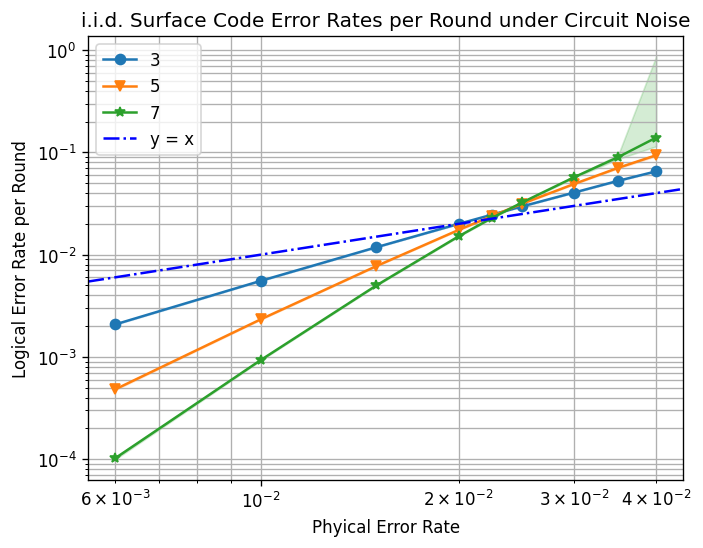

In [12]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.15)
ax.loglog()
ax.set_title("i.i.d. Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [13]:
surface_code_tasks = [
    sinter.Task(
        circuit = create_scaled_circuit_from_t1_t2(
            rounds=d*3,
            distance=d,
            t1t2_mapping=nonuniform_t1t2_dict[d],
            idle_duration_us=0.35,
            target_error_rate=noise,
            ),
        json_metadata={'d': d, 'r': d*3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [ 0.002, 0.003, 0.004, 0.005, 0.007, 0.009, 0.011, 0.014, 0.017]
]

collected_surface_code_stats_nonuniform_baseline = sinter.collect(
    num_workers=144,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5_000_000,
    print_progress=True,
    save_resume_filepath="inid.checkpoint"
)

Starting 144 workers...


In [14]:
collected_surface_code_stats_nonuniform_rmwpm = sinter.collect(
    num_workers=144,
    tasks=surface_code_tasks,
    decoders=['rmwpm'],
    custom_decoders={'rmwpm': create_sinter_rmwpm_decoder()},
    max_shots=100_000_000,
    max_errors=5_000_000,
    print_progress=True,
    save_resume_filepath="inid_rmwpm.checkpoint"
)

Starting 144 workers...


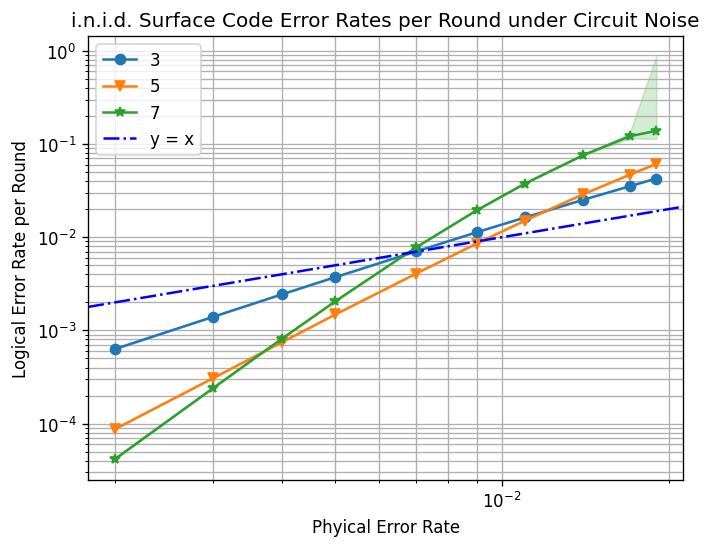

In [28]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_nonuniform_baseline,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.15)
ax.loglog()
ax.set_title("i.n.i.d. Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

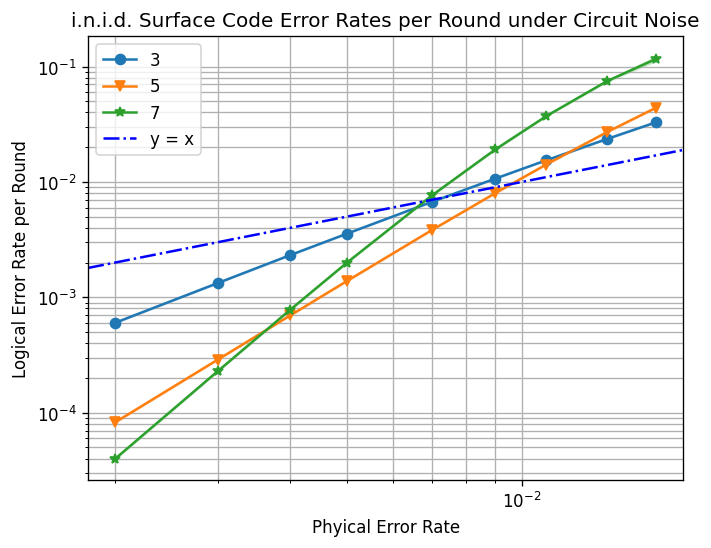

In [29]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_nonuniform_rmwpm,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.15)
ax.loglog()
ax.set_title("i.n.i.d. Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [30]:
def pseudo_threshold(records_for_one_distance):
    # records: list of (physical_p, logical_per_round), sorted by physical_p
    p_vals = np.array([r['physical'] for r in records_for_one_distance])
    l_vals = np.array([r['logical'] for r in records_for_one_distance])
    diff = l_vals - p_vals

    # exact hit?
    zeros = np.where(np.isclose(diff, 0))[0]
    if len(zeros):
        return p_vals[zeros[0]]

    # find sign change
    signs = np.sign(diff)
    flips = np.where(signs[:-1] * signs[1:] < 0)[0]
    if not len(flips):
        return None  # no intersection inside sampled range

    i = flips[0]
    p1, p2 = p_vals[i], p_vals[i+1]
    d1, d2 = diff[i], diff[i+1]
    # linear interpolation of root between (p1,d1) and (p2,d2)
    return p1 - d1 * (p2 - p1) / (d2 - d1)

def threshold_per_dictance(collected_surface_code_stats):
    records_by_distance = {}
    for stat in collected_surface_code_stats:
        p = stat.json_metadata['p']
        per_shot = stat.errors / stat.shots
        logical = sinter.shot_error_rate_to_piece_error_rate(
        shot_error_rate=per_shot,
        pieces=stat.json_metadata['r'],
    )
    
        records_by_distance.setdefault(stat.json_metadata['d'], []).append({
            'physical': p,
            'logical': logical,
        })
    
    # sort and compute
    thresholds = {}
    for d, recs in records_by_distance.items():
        recs.sort(key=lambda r: r['physical'])
        thresholds[d] = pseudo_threshold(recs)

    return thresholds

In [31]:
uniform_thresholds = threshold_per_dictance(collected_surface_code_stats)
nonuniform_thresholds_baseline = threshold_per_dictance(collected_surface_code_stats_nonuniform_baseline)
nonuniform_thresholds_rmwpm = threshold_per_dictance(collected_surface_code_stats_nonuniform_rmwpm)

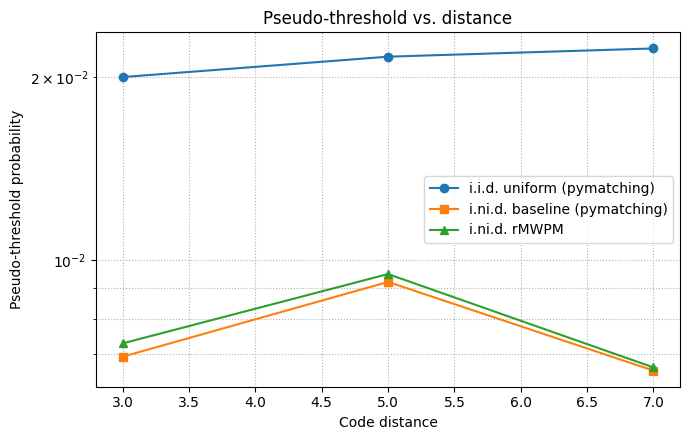

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

ax.plot(uniform_thresholds.keys(), uniform_thresholds.values(), marker='o', label='i.i.d. uniform (pymatching)')
ax.plot(nonuniform_thresholds_baseline.keys(), nonuniform_thresholds_baseline.values(), marker='s', label='i.ni.d. baseline (pymatching)')
ax.plot(nonuniform_thresholds_rmwpm.keys(), nonuniform_thresholds_rmwpm.values(), marker='^', label='i.ni.d. rMWPM')
ax.set_xlabel('Code distance')
ax.set_ylabel('Pseudo-threshold probability')
ax.set_title('Pseudo-threshold vs. distance')
ax.set_yscale('log')
ax.grid(which='both', linestyle=':')
ax.legend()
fig.tight_layout()
plt.show()